## RS Oph Gamma-ray Spectral Energy Distribution - Figure 3

This notebook remakes figure 3 from the paper:
Fermi-LAT + HESS spectra for nights 1 and 5 of HESS observations. 

In [1]:
import numpy as np
from astropy import units as u
from astropy.table import Table
from astropy.io import ascii
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from gammapy.datasets import MapDataset, FluxPointsDataset, Datasets
from gammapy.modeling.models import Models, NaimaSpectralModel, LogParabolaSpectralModel, SkyModel
from gammapy.modeling import Fit
import naima
from gammapy.estimators import FluxPoints
from astropy.table import Table

In [3]:
plt.rcParams["font.family"] = "Helvetica"

In [4]:
tev_to_erg = 1.60218

### Read in data files
Fermi-LAT data points for model fitting. Rebinned data points for a nice plot. 

In [5]:
table_LAT_090821 = Table.read('day1/sed_fermiLAT_090821.dat',format='ascii.ecsv',)
table_LAT_090821.meta["SED_TYPE"] = "dnde"
flux_points_LAT_090821 = FluxPoints(table_LAT_090821)


table_LAT_130821 = Table.read('day5/sed_fermiLAT_130821.dat',format='ascii.ecsv',)
table_LAT_130821.meta["SED_TYPE"] = "dnde"

flux_points_LAT_130821 = FluxPoints(table_LAT_130821)

In [6]:
table_LAT_090821_REBIN = Table.read('day1/sed_fermiLAT_090821_REBIN.dat',format='ascii.ecsv',)

In [7]:
eref_LAT_090821_REBIN=table_LAT_090821_REBIN['e_ref']
dnde_LAT_090821_REBIN=table_LAT_090821_REBIN['dnde']
dnde_err_LAT_090821_REBIN=table_LAT_090821_REBIN['dnde_err']
dnde_ul_LAT_090821_REBIN=table_LAT_090821_REBIN['dnde_ul']


sed_ul_09_rb=table_LAT_090821_REBIN['is_ul']
ul_index_09_rb=np.where(sed_ul_09_rb)[0]
sig_index_09_rb=np.where(sed_ul_09_rb==False)[0]


In [8]:
#Upper limit mask:
ul_index_13_mask = np.array([0,1,8,10])
ul_index_09_mask = np.array([0,1,16,19])

### Read in H.E.S.S. data
Mono available for night 1 (9th August). 
Stereo available for both nights (9th & 13th August)

In [9]:
#Obtain mono data points from dat file
table_mono_090821 = Table.read('day1/sed_hess_mono_090821.dat',format='ascii.ecsv',)
table_mono_090821.meta["SED_TYPE"] = "dnde"
flux_points_mono_090821 = FluxPoints(table_mono_090821)


In [10]:
table_HESS_090821 = Table.read('day1/sed_hess_stereo_090821.dat',format='ascii.ecsv')
table_HESS_090821.meta["SED_TYPE"] = "dnde"
flux_points_HESS_090821 = FluxPoints(table_HESS_090821)


In [11]:
table_HESS_130821 = Table.read('day5/sed_hess_stereo_130821.dat',format='ascii.ecsv')
table_HESS_130821.meta["SED_TYPE"] = "dnde"
flux_points_HESS_130821 = FluxPoints(table_HESS_130821)

In [12]:
#Night 1
sed_ul_09=flux_points_LAT_090821.table['is_ul']
ul_index_09=np.where(sed_ul_09)[0]
sig_index_09=np.where(sed_ul_09==False)[0]


eref_LAT_090821=flux_points_LAT_090821.table['e_ref']
dnde_LAT_090821=flux_points_LAT_090821.table['dnde']
dnde_err_LAT_090821=flux_points_LAT_090821.table['dnde_err']
dnde_ul_LAT_090821=flux_points_LAT_090821.table['dnde_ul']

eref_mono_090821 = flux_points_mono_090821.table['e_ref']
dnde_mono_090821 = flux_points_mono_090821.table['dnde']
dnde_err_mono_090821 = flux_points_mono_090821.table['dnde_err']

eref_090821=flux_points_HESS_090821.table['e_ref']
dnde_090821=flux_points_HESS_090821.table['dnde']
dnde_err_090821=flux_points_HESS_090821.table['dnde_err']
dnde_ul_090821=flux_points_HESS_090821.table['dnde_ul']

In [13]:
#Night 5
sed_ul_13=flux_points_LAT_130821.table['is_ul']
ul_index_13=np.where(sed_ul_13)[0]
sig_index_13=np.where(sed_ul_13==False)[0]


eref_LAT_130821=flux_points_LAT_130821.table['e_ref']
dnde_LAT_130821=flux_points_LAT_130821.table['dnde']
dnde_err_LAT_130821=flux_points_LAT_130821.table['dnde_err']
dnde_ul_LAT_130821=flux_points_LAT_130821.table['dnde_ul']


eref_130821=flux_points_HESS_130821.table['e_ref']
dnde_130821=flux_points_HESS_130821.table['dnde']
dnde_err_130821=flux_points_HESS_130821.table['dnde_err']
dnde_ul_130821=flux_points_HESS_130821.table['dnde_ul']

In [14]:
dataset_lat_090821 = FluxPointsDataset(data=flux_points_LAT_090821, name="LAT090821")
dataset_lat_130821 = FluxPointsDataset(data=flux_points_LAT_130821, name="LAT130821")

dataset_mono_090821 = FluxPointsDataset(data=flux_points_mono_090821, name="mono090821")

dataset_HESS_090821 = FluxPointsDataset(data=flux_points_HESS_090821, name="HESS090821")
dataset_HESS_130821 = FluxPointsDataset(data=flux_points_HESS_130821, name="HESS130821")

Combine data from different instruments into a single dataset for fitting:

In [15]:
datasets_090821 = Datasets()
datasets_090821.append(dataset_lat_090821)
datasets_090821.append(dataset_mono_090821)
datasets_090821.append(dataset_HESS_090821)

datasets_130821 = Datasets()
datasets_130821.append(dataset_lat_130821)
datasets_130821.append(dataset_HESS_130821)

In [16]:
energy_bounds = [1e-4, 2] * u.TeV

model_logpar_090821 = LogParabolaSpectralModel(
    alpha=1.9, amplitude="8e-10 cm-2 s-1 MeV-1", reference=1 * u.GeV, beta=0.2,
)
model_logpar_130821 = LogParabolaSpectralModel( #test
    alpha=2.05, amplitude="2e-10 cm-2 s-1 MeV-1", reference=1. * u.GeV, beta=0.12,
)


model_090821 = SkyModel(spectral_model=model_logpar_090821, name="model_090821")
model_130821 = SkyModel(spectral_model=model_logpar_130821, name="model_130821")

In [17]:
datasets_090821.models=model_090821
datasets_130821.models=model_130821

In [18]:
%%time
fit_090821 = Fit(datasets_090821)
rst_090821 = fit_090821.run()
print(rst_090821)
fit_model_090821 = datasets_090821[0].models["model_090821"].spectral_model
print(fit_model_090821)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 72
	total stat : 24.76

LogParabolaSpectralModel

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
amplitude 7.0240e-04 cm-2 s-1 TeV-1 nan nan  False 5.725e-05
reference 1.0000e-03            TeV nan nan   True 0.000e+00
    alpha 1.9795e+00                nan nan  False 4.423e-02
     beta 1.9206e-01                nan nan  False 1.157e-02
CPU times: user 107 ms, sys: 4.46 ms, total: 111 ms
Wall time: 112 ms


In [19]:
%%time
fit_130821 = Fit(datasets_130821)
rst_130821 = fit_130821.run()
print(rst_130821)
fit_model_130821 = datasets_130821[1].models["model_130821"].spectral_model
print(fit_model_130821)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 73
	total stat : 21.58

LogParabolaSpectralModel

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
amplitude 1.9356e-04 cm-2 s-1 TeV-1 nan nan  False 3.144e-05
reference 1.0000e-03            TeV nan nan   True 0.000e+00
    alpha 2.0481e+00                nan nan  False 7.364e-02
     beta 1.2245e-01                nan nan  False 1.604e-02
CPU times: user 74.8 ms, sys: 2.37 ms, total: 77.2 ms
Wall time: 75.6 ms


### Plot Figure 3

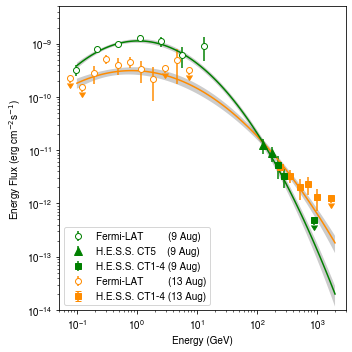

In [20]:
plt.figure(figsize=(5, 5))
color09='green'
color13='darkorange'

fit_model_130821.plot(energy_bounds,energy_power=2,color=color13,flux_unit="erg-1 cm-2 s-1",energy_unit='GeV')
fit_model_130821.plot_error(energy_bounds, energy_power=2,flux_unit="erg-1 cm-2 s-1",energy_unit='GeV')
fit_model_090821.plot(energy_bounds,energy_power=2,color=color09,flux_unit="erg-1 cm-2 s-1",energy_unit='GeV')
fit_model_090821.plot_error(energy_bounds, energy_power=2,flux_unit="erg-1 cm-2 s-1",energy_unit='GeV')


#### 09 August points

plt.errorbar(eref_LAT_090821_REBIN[sig_index_09_rb]*1e-3, 
             dnde_LAT_090821_REBIN[sig_index_09_rb]*eref_LAT_090821_REBIN[sig_index_09_rb]*eref_LAT_090821_REBIN[sig_index_09_rb]*1e-6*tev_to_erg,
             yerr=dnde_err_LAT_090821_REBIN[sig_index_09_rb]*eref_LAT_090821_REBIN[sig_index_09_rb]*eref_LAT_090821_REBIN[sig_index_09_rb]*1e-6*tev_to_erg,
             fmt ='o',color=color09,markeredgecolor=color09,markerfacecolor='white',label=r'Fermi-LAT         (9 Aug)')

plt.errorbar(eref_mono_090821*1e3,
             dnde_mono_090821*eref_mono_090821*eref_mono_090821*tev_to_erg,
             yerr=dnde_err_mono_090821*eref_mono_090821*eref_mono_090821*tev_to_erg,fmt ='^',markersize=8,
             color=color09,label=r'H.E.S.S. CT5    (9 Aug)') #mono

###13th August HESS stereo here to trick python marker display
plt.errorbar(eref_130821[:-1]*1e3,
             dnde_130821[:-1]*eref_130821[:-1]*eref_130821[:-1]*tev_to_erg,
             yerr=dnde_err_130821[:-1]*eref_130821[:-1]*eref_130821[:-1]*tev_to_erg,
             fmt ='s',color=color13)

#HESS on 9th August
plt.errorbar(eref_090821[:-1]*1e3,
             dnde_090821[:-1]*eref_090821[:-1]*eref_090821[:-1]*tev_to_erg,
             yerr=dnde_err_090821[:-1]*eref_090821[:-1]*eref_090821[:-1]*tev_to_erg,fmt ='s',
             color=color09,label=r'H.E.S.S. CT1-4 (9 Aug)') #stereo

plt.errorbar(eref_090821[-1]*1e3,
             dnde_ul_090821[-1]*eref_090821[-1]*eref_090821[-1]*tev_to_erg,
             yerr=0.2*dnde_ul_090821[-1]*eref_090821[-1]*eref_090821[-1]*tev_to_erg,
             fmt ='s', uplims=True, color=color09)


#### 13 August points

plt.errorbar(eref_LAT_130821[sig_index_13]*1e-3,
             dnde_LAT_130821[sig_index_13]*eref_LAT_130821[sig_index_13]*eref_LAT_130821[sig_index_13]*1e-6*tev_to_erg, 
             yerr=dnde_err_LAT_130821[sig_index_13]*eref_LAT_130821[sig_index_13]*eref_LAT_130821[sig_index_13]*1e-6*tev_to_erg, 
             fmt ='o',color=color13,markeredgecolor=color13,markerfacecolor='white',label=r'Fermi-LAT         (13 Aug)')
plt.errorbar(eref_LAT_130821[ul_index_13_mask]*1e-3,
            dnde_ul_LAT_130821[ul_index_13_mask]*eref_LAT_130821[ul_index_13_mask]*eref_LAT_130821[ul_index_13_mask]*1e-6*tev_to_erg, 
            yerr=0.2*dnde_ul_LAT_130821[ul_index_13_mask]*eref_LAT_130821[ul_index_13_mask]*eref_LAT_130821[ul_index_13_mask]*1e-6*tev_to_erg,
             fmt ='o',uplims=True, color=color13,markeredgecolor='darkorange',markerfacecolor='white')

plt.errorbar(eref_130821[-1]*1e3,
             dnde_ul_130821[-1]*eref_130821[-1]*eref_130821[-1]*tev_to_erg,
             yerr=0.2*dnde_ul_130821[-1]*eref_130821[-1]*eref_130821[-1]*tev_to_erg,
             fmt ='s', uplims=True, color=color13,label=r'H.E.S.S. CT1-4 (13 Aug)')#stereo


plt.legend(loc='lower left')
plt.ylim(1e-14,5e-9)
plt.xlim(0.5e-1,3e3)

plt.xlabel("Energy (GeV)")
plt.ylabel(r"Energy Flux (erg cm$^{-2}$s$^{-1}$)")

plt.tight_layout()

# plt.savefig('Fig3_LogParabola_Joint_colourstyle.png',dpi=250)